# Enemy Noise

In [7]:
import pelita
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

First we define some helper functions. They are described in detail in `nb1_matplotlib_and_numpy.ipynb`.

In [8]:
def get_maze_dimensions(walls):
    """Takes a walls list and gives the width and height of the maze"""
    maze_width = max([x for x, y in walls])+1
    maze_height = max([y for x, y in walls])+1
    return(maze_width, maze_height)

In [9]:
def draw_coords(coords, ax, params={}):
    """
    Takes a list of coordinates and draws them as scatter elements onto a pyplot ax object

    Input:
    - coords: list of tuples of x,y coordinates
    - ax: a pyplot ax object
    - params: parameters to be passed to the scatter function (e.g. shape, size, color, etc.)
    Returns:
    - ax: a pyplot ax object
    """
    if type(coords)!=list:
        coords_x, coords_y = coords
    else:
        # get separate lists of x and y coordinates from a list of tuples
        coords_x, coords_y = zip(*coords)
    ax.scatter(coords_x, coords_y, **params)
    return ax

In [10]:
def draw_game(bot, ax):
    """
    Draws game state as scatter elements given a bot object.

    Input:
    - bot : pelita bot object
    - ax : a pyplot axis object
    Returns:
    -ax : a pyplot axis object
    """
    # Depending which team we are, we need to color the board appropriately
    if bot.is_blue:
        col_home_food = "blue"
        col_home_b1 = "green"
        col_home_b2 = "darkgreen"
        col_enemy_food = "red"
        col_enemy_b1 = "orange"
        col_enemy_b2 = "darkred"
    else:
        col_home_food = "red"
        col_home_b1 = "orange"
        col_home_b2 = "darkred"
        col_enemy_food = "blue"
        col_enemy_b1 = "green"
        col_enemy_b2 = "darkgreen"

    # Then we call the draw_coords function for each type of element we want to draw.
    # Each can be customized with whichever color, shape and size you want.
    ax = draw_coords(bot.position, ax, {"c": col_home_b1, "marker": "*", "s": 400})
    ax = draw_coords(bot.walls, ax, {"c": "black", "marker": "s", "s": 250})
    ax = draw_coords(bot.other.position, ax, {"c": col_home_b2, "marker": "*", "s": 400})
    ax = draw_coords(bot.food, ax, {"c": col_home_food, "s": 100})
    ax = draw_coords(bot.enemy[0].food, ax, {"c": col_enemy_food, "s": 100})
    ax = draw_coords(bot.enemy[0].position, ax, {"c": col_enemy_b1, "marker": "*", "s": 400})
    ax = draw_coords(bot.enemy[1].position, ax, {"c": col_enemy_b2, "marker": "*", "s": 400})
    ax.axvline(np.sum(ax.get_xlim()) / 2, c="black")
    # This is to get the coordinate system to have it's origin in the top left
    yd, yu = ax.get_ylim()
    if yd < yu:
        ax.invert_yaxis()
    return ax

## Enemy Noise
When they are more than 5 fields away, the position given by `bot.enemy.position` is noisy. As the documentation says 
*"your bot has a sight-radius of 5 squares. This means that when an enemy bot is located more than 5 squares away from your bot, bot.enemy\[0].position will not be exact and bot.enemy\[0].is_noisy will be True."*

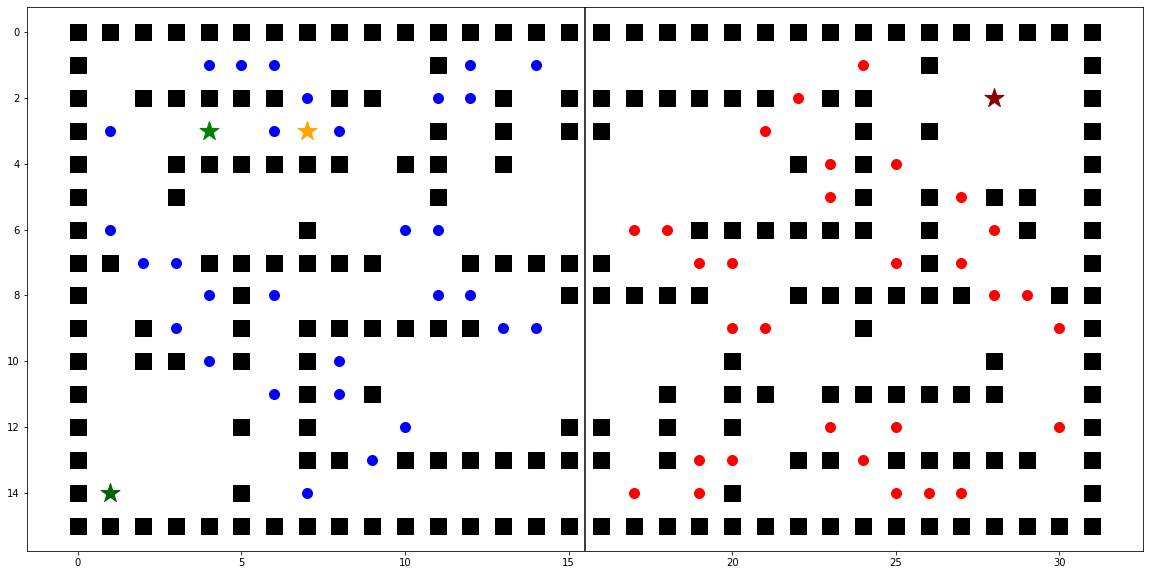

In [13]:
layout_str="""
################################
#   ...    #. .         . #    #
# #####.## ..# #######.##   ?  #
#.  0 .E.  # # ##    .  # #    #
#  ###### ## #        #.#.     #
#  #       #           .# #.## #
#.     #  ..     ..###### # .# #
##..######  #####  ..    .#.   #
#   .#.    ..  #####  ######..##
# #. # ######..     ..  #     .#
# ##.# #.           #       #  #
#     .#.#        # ## ######  #
#    # #  .    ## # #  . .    .#
#      ##.####### #.. ##.##### #
#1   # .         . .#    ...   #
################################
"""
bot = pelita.utils.setup_test_game(layout=layout_str, is_blue=True)
fig, ax = plt.subplots(figsize=(20,10))
ax = draw_game(bot, ax)

We can check the noisiness of the bots like so:

In [14]:
print("enemy 0 is noisy: ", bot.enemy[0].is_noisy)
print("enemy 1 is noisy: ", bot.enemy[1].is_noisy)

enemy 0 is noisy:  False
enemy 1 is noisy:  True


Let's find all the fields the enemy could be on. Any field that is 5 horizontal or vertical steps away is potentially the true enemy position

In [17]:
maze_width, maze_height = get_maze_dimensions(bot.walls)

This gives us a an array where each field holds the number of horizontal or 
vertical fields it is away from enemy\[1]

In [52]:
yy, xx = np.mgrid[0:maze_height, 0:maze_width]
fields_away = abs(xx - bot.enemy[1].position[0]) + abs(yy - bot.enemy[1].position[1])

One approach is making each cell hold the probability of an enemy being in this location. For this we need to normalize our array

In [57]:
enemy_prob = fields_away.copy()
# First we transform it into a binary array (enemy could be here vs. not)
enemy_prob[enemy_prob<=5] = 1 
enemy_prob[enemy_prob>5] = 0
# Then just turn into a probability density
enemy_prob = enemy_prob/np.sum(enemy_prob)
# For visualization purposes we add a small eps value to the zeros, 
# so we can display log-values. Otherwise we can't see small activations
enemy_prob[enemy_prob==0] = np.finfo(float).eps

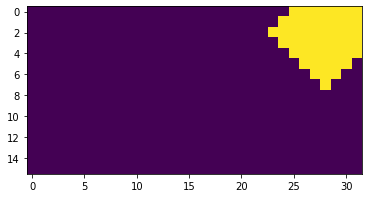

In [59]:
plt.imshow(enemy_prob)

For enemy\[0] we know exactly where it is, so we can just add that position with a probability of 1

In [60]:
enemy_prob[bot.enemy[0].position[1], bot.enemy[0].position[0]] = 1

Plot the Probabilities using pyplot:

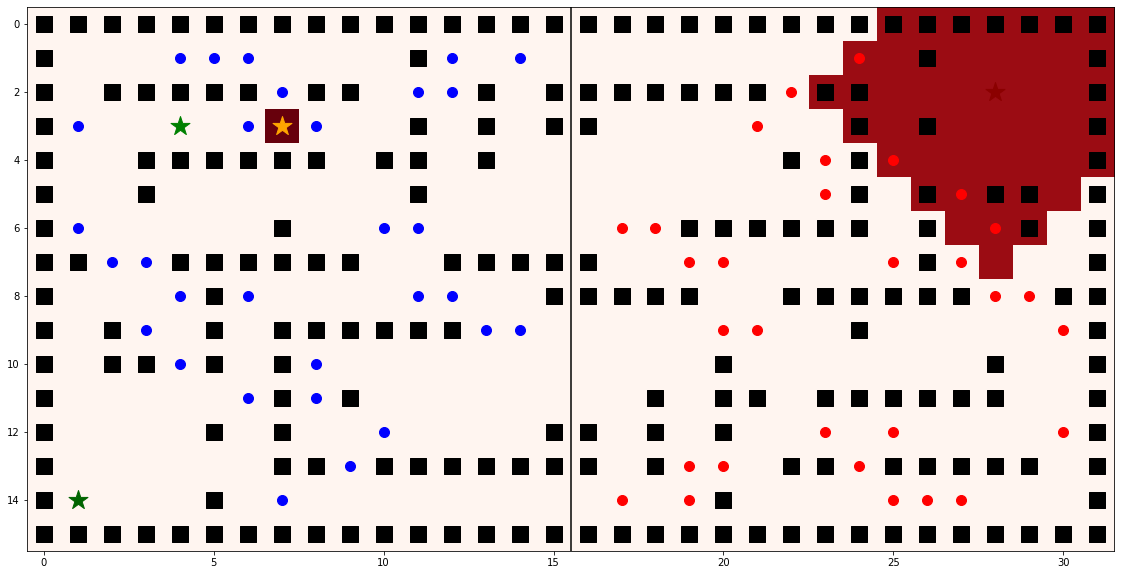

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(enemy_prob, norm=matplotlib.colors.LogNorm(), cmap="Reds")
ax = draw_game(bot, ax)

When the enemy is closer but just out of sight (e.g. 6 fields away), the noise makes it possible for the reported position to be right next to you. This example is shown below using the same procedure as above:

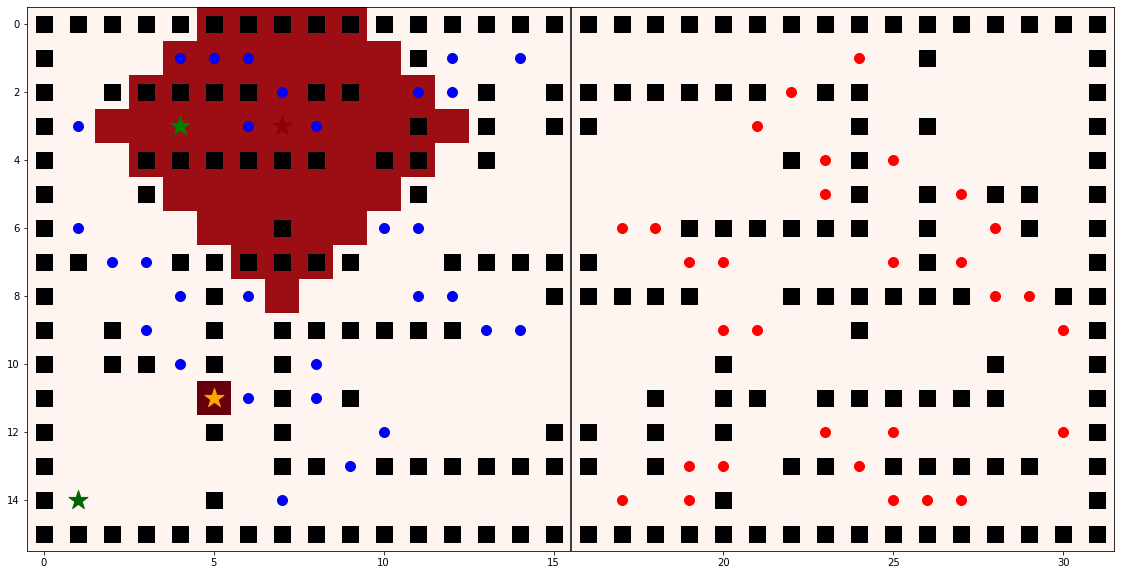

In [66]:
layout_str="""
################################
#   ...    #. .         . #    #
# #####.## ..# #######.##      #
#.  0 .?.  # # ##    .  # #    #
#  ###### ## #        #.#.     #
#  #       #           .# #.## #
#.     #  ..     ..###### # .# #
##..######  #####  ..    .#.   #
#   .#.    ..  #####  ######..##
# #. # ######..     ..  #     .#
# ##.# #.           #       #  #
#    E.#.#        # ## ######  #
#    # #  .    ## # #  . .    .#
#      ##.####### #.. ##.##### #
#1   # .         . .#    ...   #
################################
"""
bot = pelita.utils.setup_test_game(layout=layout_str, is_blue=True)
maze_width, maze_height = get_maze_dimensions(bot.walls)
yy, xx = np.mgrid[0:maze_height, 0:maze_width]
fields_away = abs(xx - bot.enemy[1].position[0]) + abs(yy - bot.enemy[1].position[1])
enemy_prob = fields_away.copy()
enemy_prob[enemy_prob<=5] = 1 
enemy_prob[enemy_prob>5] = 0
enemy_prob = enemy_prob/np.sum(enemy_prob)
enemy_prob[enemy_prob==0] = np.finfo(float).eps

enemy_prob[bot.enemy[0].position[1], bot.enemy[0].position[0]] = 1

fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(enemy_prob, norm=matplotlib.colors.LogNorm(), cmap="Reds")
ax = draw_game(bot, ax)